```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook creates plots of computational performance.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Computational performance plotting

This notebook creates plots of computational performance.



## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import re
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation
from SWESimulators import DoubleJetCase
from SWESimulators import DataAssimilationUtils as dautils

# Bar chart of data from profiler

In [2]:
def normalize(data):
    return 100*data/data.sum()

labels = ['deterministic model step', 'interpolation', 'SOAR function', 'local SVD', 'half pull']
dry_run = np.array([64.4, 21.0, 1.2, 0.0, 0, 0])
dry_run = normalize(dry_run)

no_da = np.array([88.3 + 3.0 + 2.8 + 1.2+0.1, 4.1, 0.3, 0, 0])
no_da = normalize(no_da)

ten_drifters = np.array([79.6 + 2.8 + 2.6 + 1.1 + 0.1, 11.1, 0.7, 1.2, 0.5])
ten_drifters = normalize(ten_drifters)

buoys = np.array([25.3+0.9+0.8 + 0.3, 55.7, 3.5, 8.6, 4.1])
buoys = normalize(buoys)

print(dry_run)
print(no_da)
print(ten_drifters)
print(buoys)

[74.36489607 24.24942263  1.38568129  0.          0.          0.        ]
[95.59118236  4.10821643  0.3006012   0.          0.        ]
[86.45937813 11.1334002   0.70210632  1.20361083  0.50150451]
[27.52016129 56.14919355  3.52822581  8.66935484  4.13306452]


Text(-1.093052880115478, 0.49521248093243597, '86.5%')
Text(1.0525139242443993, -0.5763804639920188, '11.1%')
Text(1.189999457671957, -0.15460042283398925, '0.7%')
Text(1.197117755278407, -0.08312087582062803, '1.2%')
Text(1.1998510686018657, -0.018905374234872017, '0.5%')


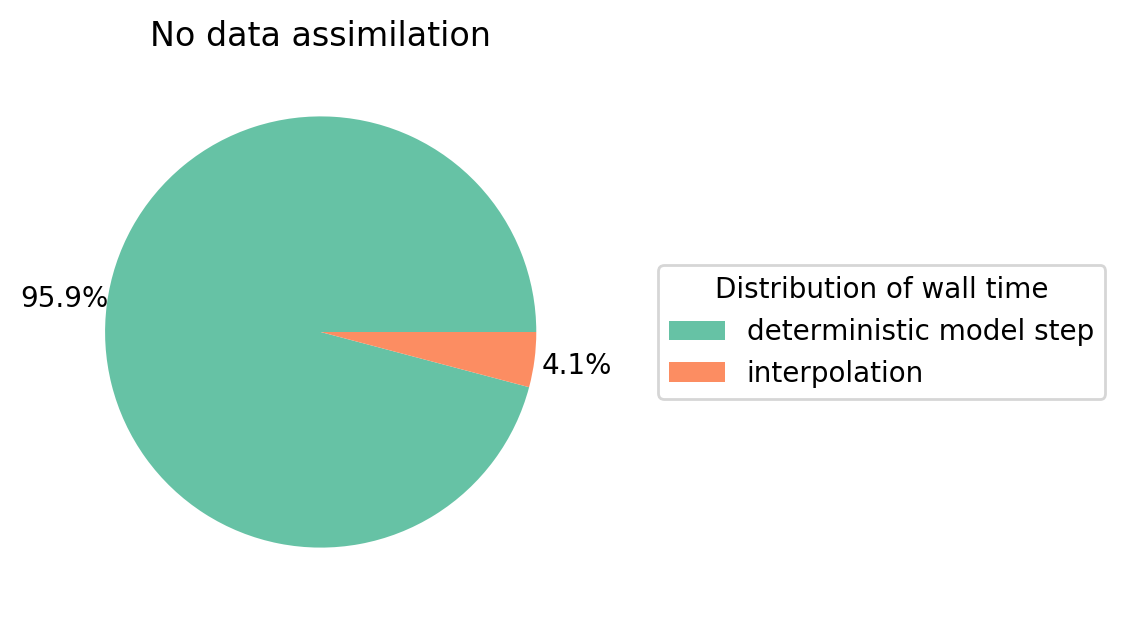

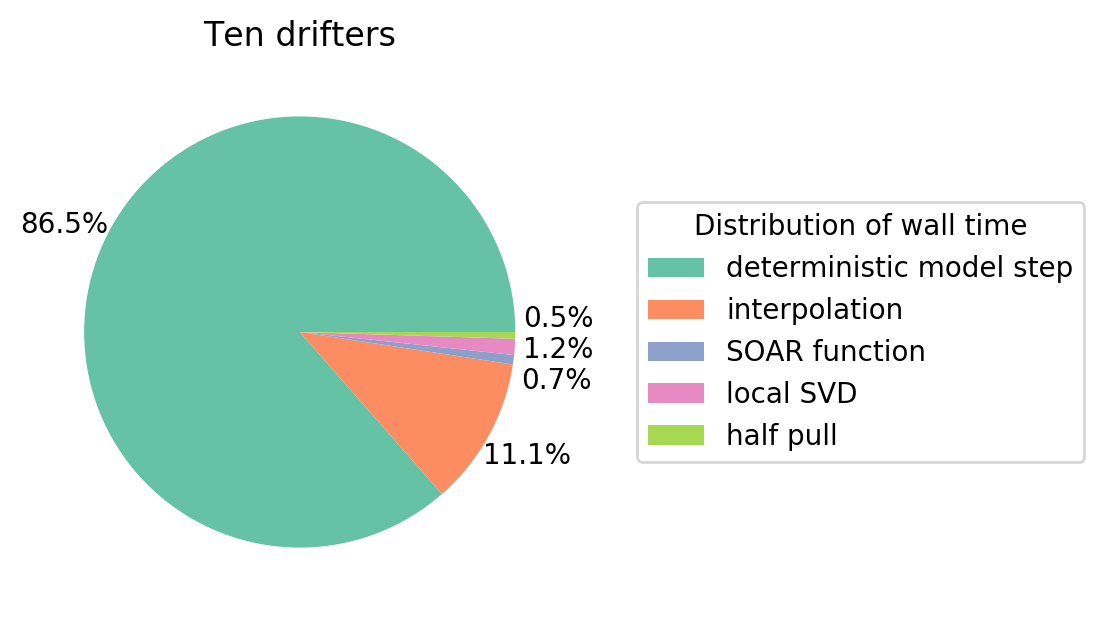

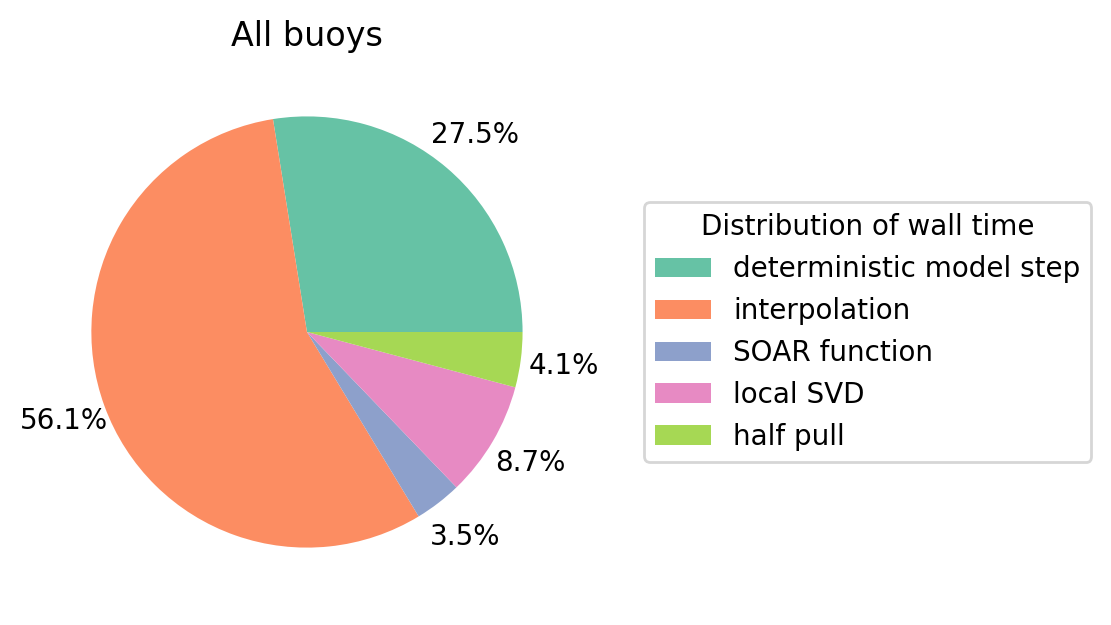

In [11]:
fig, ax = plt.subplots(figsize=(6,3.5), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(no_da[:2], colors=plt.cm.Set2.colors, 
                                  autopct='%1.1f%%', pctdistance=1.2)


ax.legend(wedges, labels[:2],
          title="Distribution of wall time",
          loc="center left",
          bbox_to_anchor=(1.1, 0, 0.5, 1))
ax.set_title("No data assimilation")
plt.savefig('performance_kernel_dist_no_da.png', bbox_inches='tight')
plt.savefig('performance_kernel_dist_no_da.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(6,3.5), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(ten_drifters, colors=plt.cm.Set2.colors, 
                                  autopct='%1.1f%%', pctdistance=1.2)

ax.legend(wedges, labels,
          title="Distribution of wall time",
          loc="center left",
          bbox_to_anchor=(1.1, 0, 0.5, 1))
for autxt in autotexts:
    print(autxt)
autotexts[2].set_position((1.189999457671957, -0.22460042283398925))
autotexts[4].set_position((1.1998510686018657, 0.058905374234872017))
ax.set_title("Ten drifters")
plt.savefig('performance_kernel_dist_ten_drifters.png', bbox_inches='tight')
plt.savefig('performance_kernel_dist_ten_drifters.pdf', bbox_inches='tight')


fig, ax = plt.subplots(figsize=(6,3.5), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(buoys, colors=plt.cm.Set2.colors, 
                                  autopct='%1.1f%%', pctdistance=1.2)

ax.legend(wedges, labels,
          title="Distribution of wall time",
          loc="center left",
          bbox_to_anchor=(1.1, 0, 0.5, 1))
ax.set_title("All buoys")
plt.savefig('performance_kernel_dist_all_buoys.png', bbox_inches='tight')
plt.savefig('performance_kernel_dist_all_buoys.pdf', bbox_inches='tight')



# Reading wall time experiments


In [14]:

experiments = ["da_experiment_2019_07_17-18_01_37",
               "da_experiment_2019_07_17-18_19_06",
               "da_experiment_2019_07_17-18_38_39",
               "da_experiment_2019_07_17-19_04_28",
               "da_experiment_2019_07_17-19_50_19",
               "da_experiment_2019_07_17-20_22_14"]

all_times = np.zeros((6,24))

def getHourlyDurations(experiment):
    main_dir = os.path.abspath("/media/havahol/Seagate Backup Plus Drive/gpu_ocean/performance_2019_07_17-18_01_36/")
    experiment_dir = os.path.join(main_dir, experiment)
    filename = os.path.join(experiment_dir, 'description.txt')

    
    data = np.empty(24)

    with open(filename) as origin_file:
        hours_found = 0
        for line in origin_file:
            
            
            # Find simulator
            match = re.findall(r'(s:  Done simulating hour ' + str(hours_found+1) + ' of day 3)', line)
            if match:
                data[hours_found] = line.split(' ')[0]
                hours_found += 1
                
    return data

def getSplitTimes(all_times):
    split_times = all_times.copy()
    for i in range(6):
        for t in range(1,24):
            split_times[i, t] = all_times[i,t] - all_times[i,t-1]
            
        print('Experiment ' + str(i) + ' min and max: ', split_times[i,:].min(), split_times[i,:].max())
    return split_times
            
            
for i in range(6):
    all_times[i,:] = getHourlyDurations(experiments[i])

print(all_times)
split_times = getSplitTimes(all_times)
print(split_times)
split_means = split_times.mean(axis=1)
print(split_means)

normalized_performance = split_means/split_means[0]
da_performance = normalized_performance - normalized_performance[0]
model_performance = normalized_performance - da_performance
print(normalized_performance)

[[  41.1   82.3  124.1  165.8  208.9  250.8  292.8  334.7  376.8  419.
   461.   503.2  545.4  587.6  629.9  672.2  714.6  757.   799.3  841.7
   884.1  926.6  969.  1011.5]
 [  46.4   93.1  139.8  186.8  234.2  282.6  329.7  376.8  424.   471.2
   518.5  565.8  613.1  660.5  708.   755.5  803.   850.6  898.1  945.6
   993.8 1041.3 1088.9 1136.5]
 [  62.   124.   186.4  248.9  311.5  374.2  437.3  500.4  563.2  626.1
   689.3  752.9  816.   879.2  942.6 1006.  1069.8 1133.  1196.4 1259.8
  1323.2 1386.7 1450.1 1513.6]
 [ 110.2  220.3  330.3  440.4  550.7  661.1  772.4  884.   995.2 1106.5
  1217.9 1328.9 1439.9 1551.  1662.4 1773.8 1885.5 1997.6 2109.3 2221.1
  2332.8 2444.1 2555.3 2666.5]
 [  76.7  153.6  230.8  308.7  386.1  463.3  540.5  617.8  695.3  772.8
   850.3  927.8 1005.4 1083.1 1160.9 1238.9 1317.2 1395.1 1473.2 1551.3
  1629.2 1707.3 1785.4 1863.5]
 [  76.5  153.   229.6  306.4  383.3  460.2  537.4  614.9  692.8  770.5
   848.3  926.  1003.8 1081.7 1159.6 1237.5 1315.3 139

(6,)
da_performance:
[0.         0.12357884 0.4963915  1.63618389 0.8423134  0.83994068]


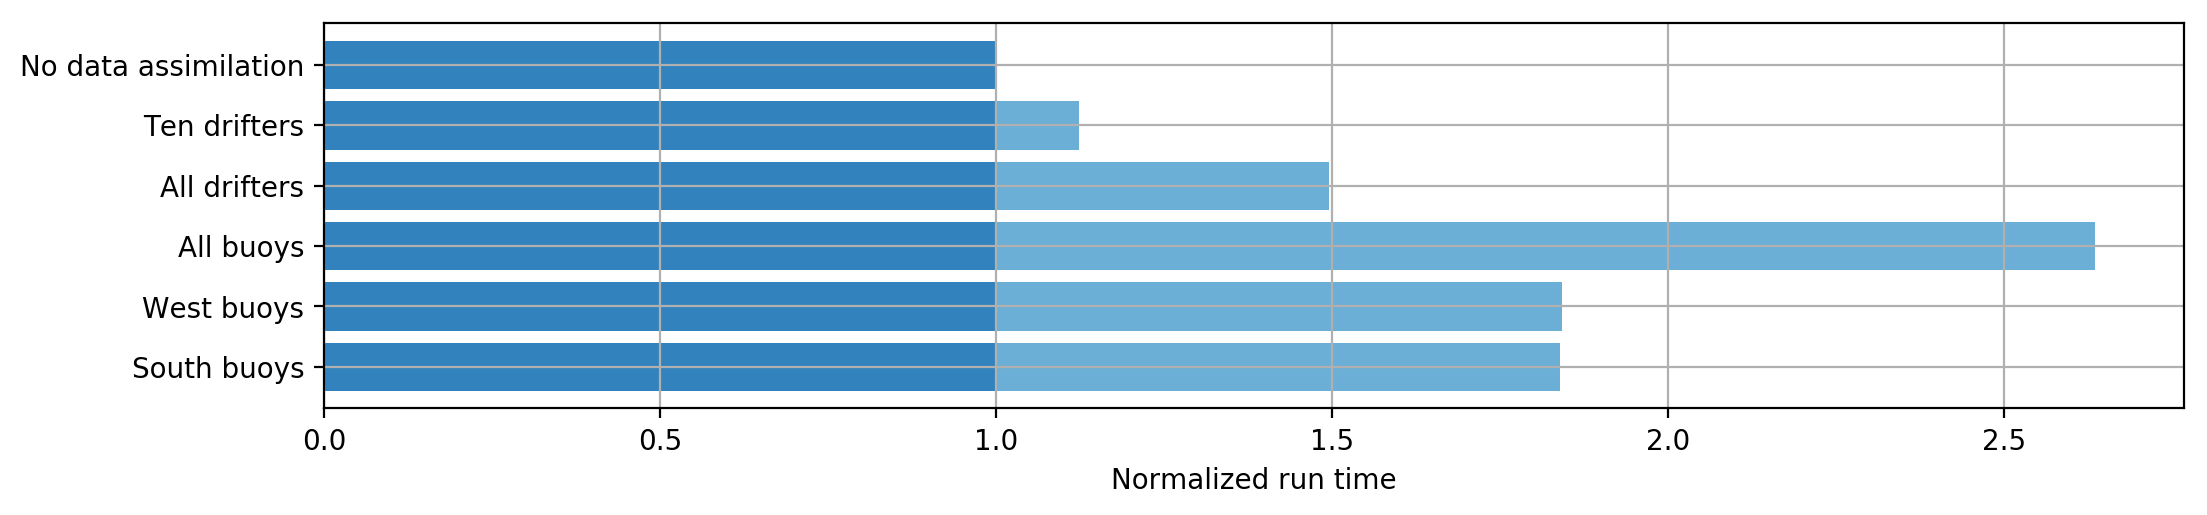

In [26]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,2.5))

# Example data
exp_labels = ('No data assimilation',
          'Ten drifters',
          'All drifters', 
          'All buoys', 
          'West buoys',
          'South buoys')
y_pos = np.arange(len(exp_labels))

# plt.cm.tab20c.colors[0]

print(model_performance.shape)

ax.barh(y_pos, model_performance, color=plt.cm.tab20c.colors[0], align='center')
ax.barh(y_pos, da_performance, color=plt.cm.tab20c.colors[1], left=model_performance, align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(exp_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Normalized run time')
ax.grid()
#ax.set_title('Wall ')

plt.savefig('performance_normalized_runtime.png', bbox_inches='tight')
plt.savefig('performance_normalized_runtime.pdf', bbox_inches='tight')

print('da_performance:')
print(da_performance)

In [19]:
time_per_obs = np.zeros(5)
num_obs = np.array([10, 64, 240, 120, 120])
for i in range(5):
    time_per_obs[i] = da_performance[i+1]/num_obs[i]
    
print(time_per_obs)
print(time_per_obs*num_obs)
expected_da_time = num_obs*time_per_obs[2]
print(expected_da_time)

[0.01235788 0.00775612 0.00681743 0.00701928 0.00699951]
[0.12357884 0.4963915  1.63618389 0.8423134  0.83994068]
[0.06817433 0.4363157  1.63618389 0.81809194 0.81809194]


(6,)


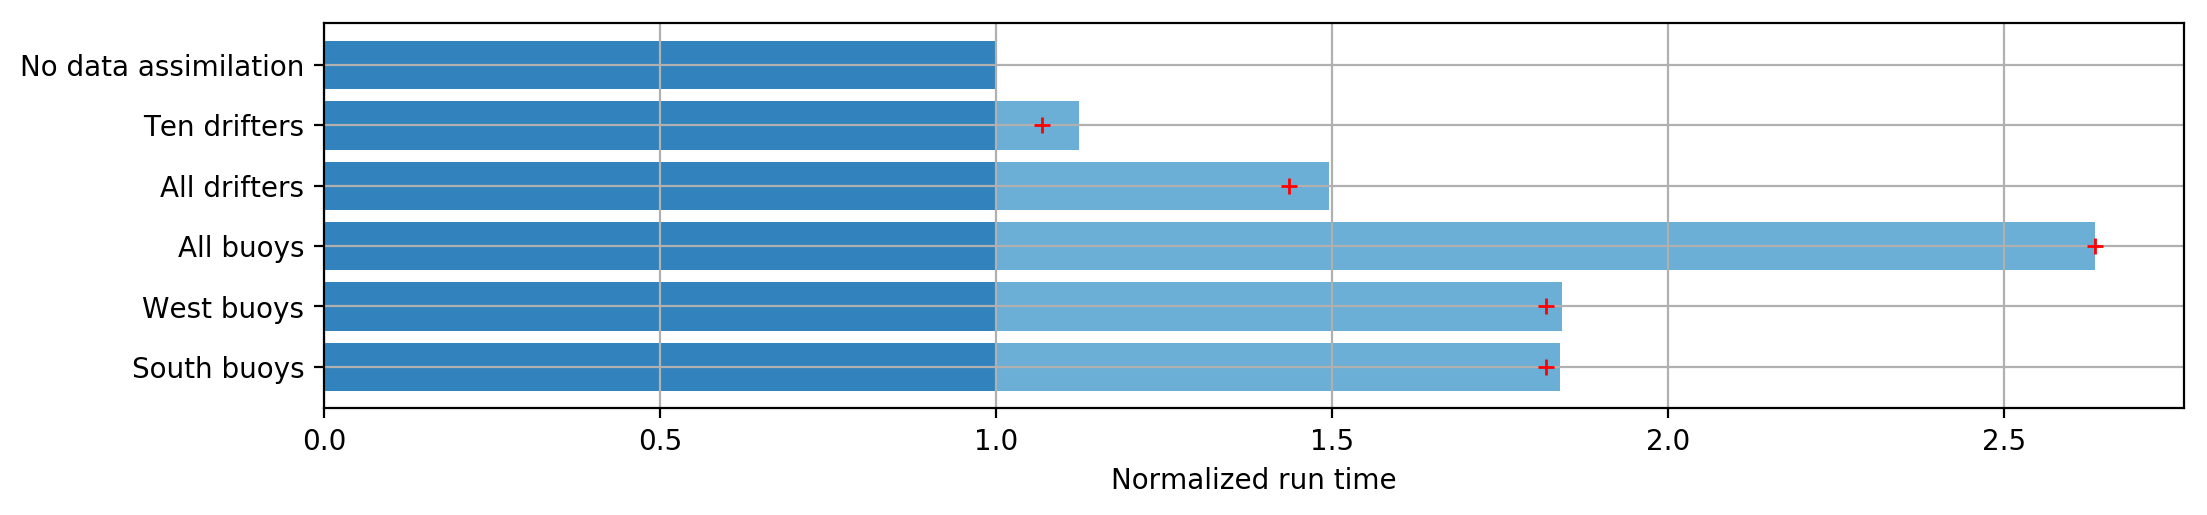

In [25]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12,2.5))

# Example data
exp_labels = ('No data assimilation',
          'Ten drifters',
          'All drifters', 
          'All buoys', 
          'West buoys',
          'South buoys')
y_pos = np.arange(len(exp_labels))

# plt.cm.tab20c.colors[0]

print(model_performance.shape)

ax.barh(y_pos, model_performance, color=plt.cm.tab20c.colors[0], align='center')
ax.barh(y_pos, da_performance, color=plt.cm.tab20c.colors[1], left=model_performance, align='center')
ax.plot(expected_da_time+1, y_pos[1:], 'r+')

ax.set_yticks(y_pos)
ax.set_yticklabels(exp_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Normalized run time')
ax.grid()
#ax.set_title('Wall ')


plt.savefig('performance_normalized_runtime_per_drifter.png', bbox_inches='tight')
plt.savefig('performance_normalized_runtime_per_drifter.pdf', bbox_inches='tight')

In [15]:
det = 74
err = 22

det*8/(det*8+err)

0.9641693811074918